### **Reinforcement Learning Concepts for CartPole Balancing**

Before diving into the project implementation, let’s build a strong foundation of the core concepts needed to master **Reinforcement Learning** (RL) and the **CartPole task**.

---

### **1. Reinforcement Learning Fundamentals**

1. **Agent and Environment**:
   - **Agent**: Learns to take actions to maximize reward.
   - **Environment**: Represents the problem (CartPole in our case) and provides feedback (state, reward, done) to the agent.

2. **Markov Decision Process (MDP)**:
   - **State (s)**: Represents the current situation in the environment (e.g., cart position, velocity, pole angle).
   - **Action (a)**: The choice made by the agent (e.g., move left or right).
   - **Reward (r)**: Feedback given after taking an action (e.g., +1 for balancing the pole).
   - **Transition (T)**: How actions move the environment to a new state.
   - Goal: Maximize cumulative reward (return).

3. **Policy (\(\pi\))**:
   - A function that maps states to actions.
   - Can be deterministic (\(a = \pi(s)\)) or stochastic (\(\pi(a|s)\)).

4. **Value Function**:
   - **State Value (\(V(s)\))**: The expected return from a state \(s\).
   - **Action Value (\(Q(s, a)\))**: The expected return from taking action \(a\) in state \(s\).

5. **Exploration vs Exploitation**:
   - **Exploration**: Trying new actions to learn about the environment.
   - **Exploitation**: Using known actions to maximize reward.

---

### **2. CartPole Problem**

1. **Goal**:
   - Balance a pole on a moving cart as long as possible.
   - Avoid the pole falling beyond a certain angle or the cart moving out of bounds.

2. **State Space**:
   - A 4-dimensional vector:
     1. Cart position.
     2. Cart velocity.
     3. Pole angle.
     4. Pole angular velocity.

3. **Action Space**:
   - Discrete: Move the cart left (0) or right (1).

4. **Reward**:
   - +1 for every step the pole remains balanced.

5. **Termination**:
   - The pole angle exceeds ±12 degrees.
   - The cart moves beyond ±2.4 units.
   - Time steps exceed the environment's maximum steps (500 in `CartPole-v1`).










# Import Libraries

In [1]:
import gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Define the DQN Agent

In [25]:

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size  # Size of state vector (e.g., 4 for CartPole)
        self.action_size = action_size  # Number of possible actions (e.g., 2 for CartPole: left or right)
        self.memory = deque(maxlen=2000)  # Replay buffer
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Exploration decay rate
        self.learning_rate = 0.001  # Learning rate for optimizer
        self.batch_size = 64  # Batch size for replay
        self.target_update_freq = 1000  # Frequency (in steps) to update the target network
        self.training_steps = 0  # Track steps for updating the target network

        # Check for GPU availability
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Build the main and target networks
        self.model = self.build_model().to(self.device)
        self.target_model = self.build_model().to(self.device)
        self.update_target_model()

        # Optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def build_model(self):
        """
        Build a simple feedforward neural network for Q-value approximation.
        """
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size)
        )
        return model

    def update_target_model(self):
        """
        Copy weights from the main model to the target model.
        """
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        """
        Store an experience (state, action, reward, next_state, done) in the replay buffer.
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, evaluate=False):
        """
        Select an action using an epsilon-greedy strategy.
        If `evaluate` is True, always select the action with the highest Q-value.
        """
        if not evaluate and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Random action
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # Add batch dimension
        q_values = self.model(state)
        return torch.argmax(q_values).item()  # Action with max Q-value

    def replay(self):
        """
        Train the model by sampling a minibatch from the replay buffer.
        """
        if len(self.memory) < self.batch_size:
            return  # Not enough samples to train yet

        # Sample a minibatch
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Compute target Q-values
        q_targets = rewards + (1 - dones) * self.gamma * torch.max(self.target_model(next_states), dim=1)[0]

        # Compute current Q-values
        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()

        # Compute loss
        loss = nn.MSELoss()(q_values, q_targets.detach())

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)  # Gradient clipping
        self.optimizer.step()

        # Update exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Increment training step
        self.training_steps += 1

        # Update target network periodically
        if self.training_steps % self.target_update_freq == 0:
            self.update_target_model()

    def evaluate(self, env, num_episodes=10):
        """
        Evaluate the agent by running it in the environment without exploration.
        """
        total_rewards = []
        for _ in range(num_episodes):
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                action = self.act(state, evaluate=True)  # Use the policy without exploration
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
            total_rewards.append(episode_reward)
        return np.mean(total_rewards)


# Train the agent 

In [26]:
import numpy as np
import gym
import torch

# Initialize the environment
env = gym.make('CartPole-v1', render_mode=None)  # Load CartPole environment
state_size = env.observation_space.shape[0]  # State size
action_size = env.action_space.n  # Number of actions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

agent = DQNAgent(state_size, action_size)  # Initialize the DQN agent
num_episodes = 500
target_update = 10  # Update target model every 10 episodes
scores = []

for e in range(num_episodes):
    # Reset the environment
    state, info = env.reset()
    state = np.array(state, dtype=np.float32)  # Ensure state is in float32 format
    
    total_reward = 0
    terminated = False
    truncated = False
    while not (terminated or truncated):
        # Select an action
        action = agent.act(state)
        
        # Take the action in the environment
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = np.array(next_state, dtype=np.float32)  # Ensure next_state is float32
        
        # Update `done` logic
        done = terminated or truncated
        
        # Penalize for failure
        reward = reward if not done else -10
        
        # Store the experience in the replay buffer
        agent.remember(state, action, reward, next_state, done)
        
        # Update the current state
        state = next_state
        
        total_reward += reward

        # Train the agent
        agent.replay()

    scores.append(total_reward)
    print(f"Episode {e + 1}/{num_episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")


Episode 1/500, Score: 5.0, Epsilon: 1.00
Episode 2/500, Score: 16.0, Epsilon: 1.00
Episode 3/500, Score: 27.0, Epsilon: 0.91
Episode 4/500, Score: 1.0, Epsilon: 0.86
Episode 5/500, Score: 8.0, Epsilon: 0.78


/var/folders/br/00zjfg9d62j1qgx9kb7y9h4c0000gp/T/ipykernel_50592/1898691760.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states).to(self.device)


Episode 6/500, Score: 5.0, Epsilon: 0.72
Episode 7/500, Score: 22.0, Epsilon: 0.61
Episode 8/500, Score: 8.0, Epsilon: 0.56
Episode 9/500, Score: 2.0, Epsilon: 0.52
Episode 10/500, Score: 8.0, Epsilon: 0.47
Episode 11/500, Score: 7.0, Epsilon: 0.43
Episode 12/500, Score: 7.0, Epsilon: 0.40
Episode 13/500, Score: 10.0, Epsilon: 0.36
Episode 14/500, Score: 19.0, Epsilon: 0.31
Episode 15/500, Score: 11.0, Epsilon: 0.27
Episode 16/500, Score: 18.0, Epsilon: 0.24
Episode 17/500, Score: 5.0, Epsilon: 0.22
Episode 18/500, Score: 9.0, Epsilon: 0.20
Episode 19/500, Score: 8.0, Epsilon: 0.18
Episode 20/500, Score: 15.0, Epsilon: 0.16
Episode 21/500, Score: 16.0, Epsilon: 0.14
Episode 22/500, Score: 18.0, Epsilon: 0.12
Episode 23/500, Score: 34.0, Epsilon: 0.10
Episode 24/500, Score: 35.0, Epsilon: 0.08
Episode 25/500, Score: 32.0, Epsilon: 0.06
Episode 26/500, Score: 26.0, Epsilon: 0.05
Episode 27/500, Score: 8.0, Epsilon: 0.05
Episode 28/500, Score: 33.0, Epsilon: 0.04
Episode 29/500, Score: 28

# Plotting rewards 

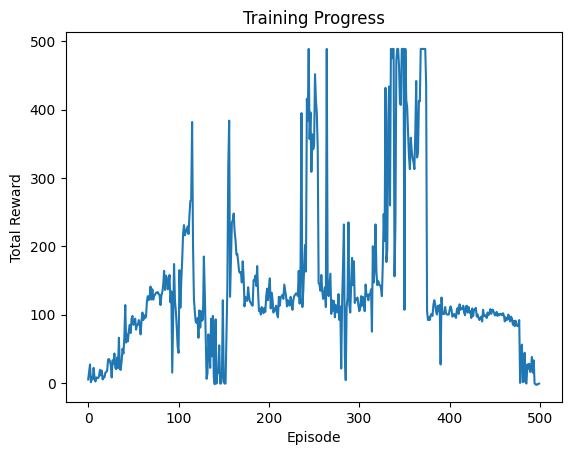

In [29]:
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()

# Testing the DQN Agent 

In [30]:


# Initialize the environment with render_mode
env = gym.make("CartPole-v1", render_mode="human")

# Set the agent to evaluation mode
agent.model.eval()

# Number of episodes for testing
num_test_episodes = 10

# List to store total rewards
total_rewards = []

for episode in range(num_test_episodes):
    # Reset the environment and unpack the observation
    state, _ = env.reset()  # Only take the observation, ignore metadata
    state = np.float32(state)  # Ensure state is float
    total_reward = 0
    done = False

    while not done:
        # Use the learned policy to act (no exploration)
        action = agent.act(state)

        # Take action in the environment
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated  # Combine done and truncated flags

        # Accumulate the reward
        total_reward += reward

        # Update the current state
        state = next_state

    total_rewards.append(total_reward)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

env.close()

# Calculate and display the average reward
average_reward = np.mean(total_rewards)
print(f"Average Test Reward over {num_test_episodes} episodes: {average_reward:.2f}")


Episode 1: Total Reward = 9.0
Episode 2: Total Reward = 10.0
Episode 3: Total Reward = 9.0
Episode 4: Total Reward = 11.0
Episode 5: Total Reward = 9.0
Episode 6: Total Reward = 8.0
Episode 7: Total Reward = 9.0
Episode 8: Total Reward = 8.0
Episode 9: Total Reward = 9.0
Episode 10: Total Reward = 9.0
Average Test Reward over 10 episodes: 9.10


# Implementation of policy gradient 

In [11]:

class PolicyGradientAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99  # Discount factor
        self.policy = nn.Sequential(
            nn.Linear(state_size, 24),
            nn.ReLU(),
            nn.Linear(24, action_size),
            nn.Softmax(dim=-1)  # Outputs action probabilities
        )
        self.optimizer = optim.Adam(self.policy.parameters(), lr=0.001)
        self.memory = []  # Stores (state, action, reward) for training

    def remember(self, state, action, reward):
        self.memory.append((state, action, reward))  # Store experience

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension
        probabilities = self.policy(state)
        action = np.random.choice(self.action_size, p=probabilities.detach().numpy().squeeze())
        return action

    def train(self):
        R = 0  # Cumulative reward
        returns = []
        # Compute returns in reverse order
        for _, _, reward in reversed(self.memory):
            R = reward + self.gamma * R
            returns.insert(0, R)
        returns = torch.FloatTensor(returns)
        # Normalize returns for numerical stability
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)
        self.optimizer.zero_grad()
        loss = 0
        # Compute loss for each memory entry
        for (state, action, _), Gt in zip(self.memory, returns):
            state = torch.FloatTensor(state).unsqueeze(0)
            probabilities = self.policy(state)
            log_prob = torch.log(probabilities.squeeze(0)[action])
            loss -= log_prob * Gt  # Policy Gradient loss
        loss.backward()  # Backpropagate gradients
        self.optimizer.step()
        self.memory = []  # Clear memory after training



# Train the policy gradient agent

In [22]:
env = gym.make('CartPole-v1', render_mode=None)  # CartPole environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
pg_agent = PolicyGradientAgent(state_size, action_size)

# Training parameters
num_episodes = 500  # Number of training episodes


    # Training Loop with Detailed Logging
for episode in range(num_episodes):
    state, _ = env.reset()  # Reset the environment
    state = np.array(state, dtype=np.float32)  # Ensure state is float32
    done = False
    total_reward = 0

    while not done:
        action = pg_agent.act(state)  # Select action
        next_state, reward, done, truncated, _ = env.step(action)  # Take action
        done = done or truncated  # Combine done and truncated
        next_state = np.array(next_state, dtype=np.float32)  # Ensure next_state is float32
        pg_agent.remember(state, action, reward)  # Store experience
        state = next_state  # Update state
        total_reward += reward

    pg_agent.train()  # Train the policy after each episode
    print(f"Episode {episode + 1}/{num_episodes}, Score: {total_reward:.2f}")



/Users/Senjuti/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1/500, Score: 40.00
Episode 2/500, Score: 11.00
Episode 3/500, Score: 21.00
Episode 4/500, Score: 17.00
Episode 5/500, Score: 13.00
Episode 6/500, Score: 28.00
Episode 7/500, Score: 41.00
Episode 8/500, Score: 26.00
Episode 9/500, Score: 15.00
Episode 10/500, Score: 18.00
Episode 11/500, Score: 24.00
Episode 12/500, Score: 13.00
Episode 13/500, Score: 42.00
Episode 14/500, Score: 13.00
Episode 15/500, Score: 13.00
Episode 16/500, Score: 12.00
Episode 17/500, Score: 11.00
Episode 18/500, Score: 19.00
Episode 19/500, Score: 17.00
Episode 20/500, Score: 29.00
Episode 21/500, Score: 55.00
Episode 22/500, Score: 15.00
Episode 23/500, Score: 27.00
Episode 24/500, Score: 15.00
Episode 25/500, Score: 33.00
Episode 26/500, Score: 31.00
Episode 27/500, Score: 11.00
Episode 28/500, Score: 33.00
Episode 29/500, Score: 8.00
Episode 30/500, Score: 20.00
Episode 31/500, Score: 13.00
Episode 32/500, Score: 17.00
Episode 33/500, Score: 19.00
Episode 34/500, Score: 36.00
Episode 35/500, Score: 1

# Plotting total rewards

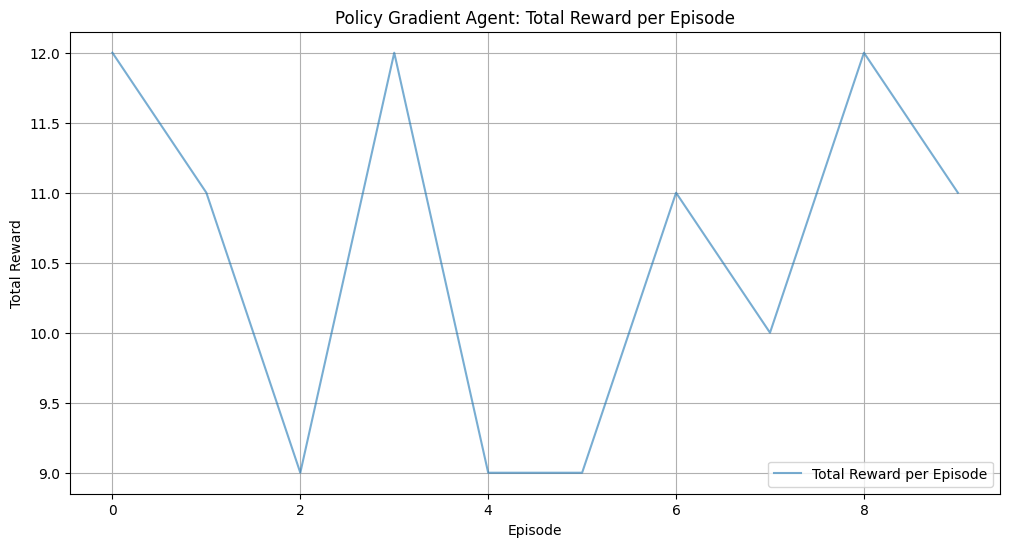

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(total_rewards, label="Total Reward per Episode", alpha=0.6)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Policy Gradient Agent: Total Reward per Episode")
plt.legend()
plt.grid()
plt.show()

# Testing the policy based agent 

In [28]:
# Testing Loop for Policy Gradient Agent
num_test_episodes = 10  # Number of episodes to test
total_test_rewards = []

for episode in range(num_test_episodes):
    state, _ = env.reset()  # Reset the environment
    state = np.array(state, dtype=np.float32)  # Ensure state is float32
    done = False
    total_reward = 0

    while not done:
        action = pg_agent.act(state)  # Select action using the trained policy
        next_state, reward, done, truncated, _ = env.step(action)  # Take action
        done = done or truncated  # Combine done and truncated flags
        state = np.array(next_state, dtype=np.float32)  # Update state
        total_reward += reward

    total_test_rewards.append(total_reward)
    print(f"Test Episode {episode + 1}/{num_test_episodes}, Total Reward: {total_reward:.2f}")

# Print Summary
average_test_reward = np.mean(total_test_rewards)
print(f"Average Test Reward over {num_test_episodes} Episodes: {average_test_reward:.2f}")


Test Episode 1/10, Total Reward: 43.00
Test Episode 2/10, Total Reward: 59.00
Test Episode 3/10, Total Reward: 58.00
Test Episode 4/10, Total Reward: 45.00
Test Episode 5/10, Total Reward: 137.00
Test Episode 6/10, Total Reward: 118.00
Test Episode 7/10, Total Reward: 84.00
Test Episode 8/10, Total Reward: 100.00
Test Episode 9/10, Total Reward: 130.00
Test Episode 10/10, Total Reward: 110.00
Average Test Reward over 10 Episodes: 88.40


# In this case 
    Average Reward over 10 Episodes (DQN): 9.10

        This indicates that the DQN agent is not performing well at the task of balancing the cart-pole.
        A low reward implies that the agent struggles to keep the pole balanced for a long time, likely failing quickly in each episode.

    * Average Test Reward over 10 Episodes (Policy-Based Agent): 88.40
        This is a significantly higher reward, indicating that the policy-based agent is much better at the task.
        It suggests the agent successfully balances the pole for a longer time, consistently achieving higher performance.